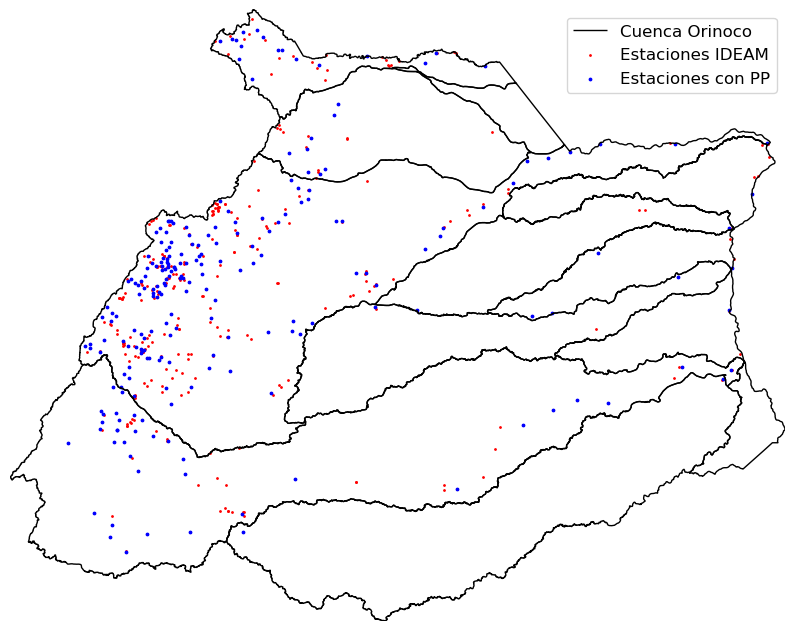

In [1]:
########################################################
#  FILTRAR LAS ESTACIONES CON DATOS EN EL SHAPE
##########################################################

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import os


# Cargar el archivo Excel y obtener los nombres de las columnas
cuenca_orinoco = gpd.read_file("shp/cuenca_orinoco/cuenca_orinoco.shp")
df_excel = pd.read_excel("datos_analisis\precipitacion_mensual_ideam.xlsx")
column_names = df_excel.columns.tolist()[1:]

# Cargar el shapefile de estaciones en un GeoDataFrame
estaciones_orinoquia = gpd.read_file("shp/estaciones_orinoquia/estaciones_orinoquia.shp")

# Filtrar el GeoDataFrame según los nombres de las estaciones en el archivo Excel
# Asumiendo que la columna que contiene los nombres de las estaciones en el shapefile se llama 'nombre_estacion'
estaciones_pp = estaciones_orinoquia[estaciones_orinoquia['nombre'].isin(column_names)]

# Visualizar
fig, ax = plt.subplots(figsize=(10, 10))  # Ajusta el tamaño de la figura
cuenca_orinoco.boundary.plot(ax=ax, linewidth=1, color='black', label='Cuenca Orinoco')
estaciones_orinoquia.plot(ax=ax, markersize=1, color='red', label='Estaciones IDEAM')
estaciones_pp.plot(ax=ax, markersize=3, color='blue', label='Estaciones con PP')
x_min, y_min, x_max, y_max = cuenca_orinoco.total_bounds
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.axis('off')
ax.grid(False)  # Quitar las grillas
ax.legend(loc='upper right', fontsize=12)  # Personalizar la leyenda
plt.show() # Mostrar la figura

fig.savefig("shp/mapa_estaciones_pp_orinoquia.png", dpi=300, bbox_inches='tight', pad_inches=0.5, transparent=True)

# Guardar el GeoDataFrame filtrado como un nuevo shapefile si es necesario
if not os.path.exists('shp/estaciones_pp_orinoquia'): os.makedirs("shp/estaciones_pp_orinoquia")
estaciones_pp.to_file("shp/estaciones_pp_orinoquia/estaciones_pp_orinoquia.shp")

In [ ]:
########################################################################
#  EXTRAER DATOS DE CHIRPS - VERSIÓN CORREGIDA Y OPTIMIZADA
########################################################################
import rasterio
import os
import pandas as pd
import geopandas as gpd

print("Iniciando el proceso de extracción de datos...")

# --- 1. Cargar el shapefile ---
try:
    shapefile_path = 'shp/estaciones_pp_orinoquia/estaciones_pp_orinoquia.shp'
    estaciones_orinoquia = gpd.read_file(shapefile_path)
    print(f"Shapefile '{shapefile_path}' cargado correctamente con {len(estaciones_orinoquia)} estaciones.")
except Exception as e:
    print(f"Error al cargar el shapefile: {e}")
    exit()

# --- 2. Verificar y Corregir Nombres de Estaciones Duplicados (Causa del Error) ---
station_names = estaciones_orinoquia['nombre']
if station_names.duplicated().any():
    print("¡Advertencia! Se encontraron nombres de estaciones duplicados en el shapefile.")
    print("Esto causa el error 'InvalidIndexError'.")
    print("Se crearán nombres de columna únicos usando el formato 'nombre_índice' para evitar el error.")
    # Create unique column names by appending the GeoDataFrame index
    column_names = (station_names + '_' + estaciones_orinoquia.index.astype(str)).tolist()
else:
    print("No se encontraron nombres duplicados. Se usarán los nombres originales de las estaciones.")
    column_names = station_names.tolist()

# --- 3. Preparar para la extracción de datos ---
# Get the list of raster files and sort them to ensure chronological order
raster_folder = 'datos_chirps'
try:
    raster_files = sorted([f for f in os.listdir(raster_folder) if f.endswith('.tif')])
    if not raster_files:
        print(f"Error: No se encontraron archivos .tif en la carpeta '{raster_folder}'.")
        exit()
    print(f"Se encontraron {len(raster_files)} archivos raster para procesar.")
except FileNotFoundError:
    print(f"Error: La carpeta '{raster_folder}' no existe.")
    exit()


# Get station coordinates once before the loop
coordinates = [(point.geometry.x, point.geometry.y) for idx, point in estaciones_orinoquia.iterrows()]

# --- 4. Extraer Datos (Método Eficiente) ---
# Use a list to store data from each row, which is much faster than concatenating DataFrames in a loop
extracted_data_list = []

for i, raster_file in enumerate(raster_files):
    print(f"Procesando archivo {i+1}/{len(raster_files)}: {raster_file}")
    try:
        with rasterio.open(os.path.join(raster_folder, raster_file)) as src:
            # Extract the date from the raster filename
            date_from_file = os.path.splitext(raster_file)[0]
            
            # Initialize a dictionary for the current row's data
            new_row = {'Fecha_Original': date_from_file}
            
            # Sample all points at once for the current raster (more efficient)
            # The result is a generator, so we convert it to a list of values
            point_values = [val[0] for val in src.sample(coordinates)]
            
            # Populate the dictionary with station names and their corresponding raster values
            for station_name, value in zip(column_names, point_values):
                new_row[station_name] = value
            
            # Append the completed dictionary to our list
            extracted_data_list.append(new_row)
    except Exception as e:
        print(f"No se pudo procesar el archivo {raster_file}. Error: {e}")


# --- 5. Crear el DataFrame Final y Asignar Fechas ---
# Create the DataFrame from the list of dictionaries (much more efficient)
if not extracted_data_list:
    print("No se extrajo ningún dato. El proceso terminará.")
    exit()

df_precipitacion = pd.DataFrame(extracted_data_list)

# Generate a date range from January 1981. The frequency 'MS' means Month Start.
# This assumes your raster files are monthly and start from that date.
try:
    dates = pd.date_range(start='1981-01-01', periods=len(df_precipitacion), freq='MS').strftime('%Y-%m-%d')
    # Assign the new generated dates to a 'Fecha' column
    df_precipitacion['Fecha'] = dates
except Exception as e:
    print(f"Error generando el rango de fechas: {e}")


# Reorder columns to have the new 'Fecha' column first
final_columns = ['Fecha', 'Fecha_Original'] + column_names
df_precipitacion = df_precipitacion[final_columns]


# --- 6. Guardar los resultados en un archivo Excel ---
output_folder = 'datos_analisis'
output_file = os.path.join(output_folder, 'pp_mes_chirps.xlsx')

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

df_precipitacion.to_excel(output_file, index=False)

print("\n----------------------------------------------------------")
print(f"¡Proceso completado exitosamente!")
print(f"Resultados guardados en: {output_file}")
print("----------------------------------------------------------")

Iniciando el proceso de extracción de datos...
Shapefile 'shp/estaciones_pp_orinoquia/estaciones_pp_orinoquia.shp' cargado correctamente con 227 estaciones.
¡Advertencia! Se encontraron nombres de estaciones duplicados en el shapefile.
Esto causa el error 'InvalidIndexError'.
Se crearán nombres de columna únicos usando el formato 'nombre_índice' para evitar el error.
Se encontraron 528 archivos raster para procesar.
Procesando archivo 1/528: chirps-v2.0.1981.01.tif
Procesando archivo 2/528: chirps-v2.0.1981.02.tif
Procesando archivo 3/528: chirps-v2.0.1981.03.tif
Procesando archivo 4/528: chirps-v2.0.1981.04.tif
Procesando archivo 5/528: chirps-v2.0.1981.05.tif
Procesando archivo 6/528: chirps-v2.0.1981.06.tif
Procesando archivo 7/528: chirps-v2.0.1981.07.tif
Procesando archivo 8/528: chirps-v2.0.1981.08.tif
Procesando archivo 9/528: chirps-v2.0.1981.09.tif
Procesando archivo 10/528: chirps-v2.0.1981.10.tif
Procesando archivo 11/528: chirps-v2.0.1981.11.tif
Procesando archivo 12/528: c